In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
from scipy import linalg
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import cv2
from collections import Counter
import pg_fitter_tools as fit
import sk_geo_tools as sk

In [4]:
%matplotlib notebook

In [5]:
focal_length = [2.760529621789217e+03, 2.767014510543478e+03]
principle_point = [1.914303537872458e+03, 1.596386868474348e+03]
radial_distortion = [-0.2398, 0.1145]
tangential_distortion = [0, 0]

In [84]:
all_pmt_locations = fit.read_3d_feature_locations("SK_all_PMT_locations.txt")
offset = np.array([0, 250])
image_feature_locations = {}
image_feature_locations.update(fit.read_image_feature_locations("BarrelSurveyFar_TopInjector_PD3/BarrelSurveyFar_TopInjector_median_texts/045.txt", offset=offset))
image_feature_locations.update(fit.read_image_feature_locations("BarrelSurveyFar_TopInjector_PD3/BarrelSurveyFar_TopInjector_median_texts/046.txt", offset=offset))
image_feature_locations.update(fit.read_image_feature_locations("BarrelSurveyFar_TopInjector_PD3/BarrelSurveyFar_TopInjector_median_texts/047.txt", offset=offset))
image_feature_locations.update(fit.read_image_feature_locations("BarrelSurveyFar_TopInjector_PD3/BarrelSurveyFar_TopInjector_median_texts/048.txt", offset=offset))
image_feature_locations.update(fit.read_image_feature_locations("BarrelSurveyFar_TopInjector_PD3/BarrelSurveyFar_TopInjector_median_texts/086.txt", offset=offset))
image_feature_locations.update(fit.read_image_feature_locations("BarrelSurveyFar_TopInjector_PD3/BarrelSurveyFar_TopInjector_median_texts/087.txt", offset=offset))
image_feature_locations.update(fit.read_image_feature_locations("BarrelSurveyFar_TopInjector_PD3/BarrelSurveyFar_TopInjector_median_texts/124.txt", offset=offset))
image_feature_locations.update(fit.read_image_feature_locations("BarrelSurveyFar_TopInjector_PD3/BarrelSurveyFar_TopInjector_median_texts/125.txt", offset=offset))
image_feature_locations.update(fit.read_image_feature_locations("BarrelSurveyFar_TopInjector_PD3/BarrelSurveyFar_TopInjector_median_texts/126.txt", offset=offset))
image_feature_locations.update(fit.read_image_feature_locations("BarrelSurveyFar_TopInjector_PD3/BarrelSurveyFar_TopInjector_median_texts/127.txt", offset=offset))
image_feature_locations.update(fit.read_image_feature_locations("BarrelSurveyFar_TopInjector_PD3/BarrelSurveyFar_TopInjector_median_texts/236.txt", offset=offset))
image_feature_locations.update(fit.read_image_feature_locations("BarrelSurveyFar_TopInjector_PD3/BarrelSurveyFar_TopInjector_median_texts/237.txt", offset=offset))
image_feature_locations.update(fit.read_image_feature_locations("BarrelSurveyFar_TopInjector_PD3/BarrelSurveyFar_TopInjector_median_texts/238.txt", offset=offset))
image_feature_locations.update(fit.read_image_feature_locations("BarrelSurveyFar_TopInjector_PD3/BarrelSurveyFar_TopInjector_median_texts/239.txt", offset=offset))
image_feature_locations.update(fit.read_image_feature_locations("BarrelSurveyFar_TopInjector_PD3/BarrelSurveyFar_TopInjector_median_texts/240.txt", offset=offset))

In [7]:
# swap out -25 and -00 for features in images where both exist
for im in image_feature_locations.values():
    for feat, loc in im.items():
        if feat[-2:] == "00" and feat[:-2]+"25" in im:
            tmp = loc
            im[feat] = im[feat[:-2]+"25"]
            im[feat[:-2]+"25"] = tmp

In [8]:
# choose features that appear in 2+ images
feature_counts = Counter([f for i in image_feature_locations.values() for f in i.keys()])
common_features = [f for f in feature_counts if feature_counts[f] > 1]
pmt_locations = {k: p for k, p in all_pmt_locations.items() if k in common_features}
bolt_locations = sk.get_bolt_locations_barrel(pmt_locations)
#all_pmt_locations[common_features[10]]
#for k, i in image_feature_locations.items():
#    image_feature_locations[k] = {j: f for j, f in i.items() if j in common_features}
#pmt_locations = {k: v for k, v in pmt_locations.items() if k in common_features}

In [9]:
common_bolt_locations = {k: f for k, f in bolt_locations.items() if k in common_features}
common_feature_locations = {**pmt_locations, **common_bolt_locations}
common_image_pmt_locations = {
    k: {j: f for j, f in i.items() if j in common_features and j in pmt_locations}
    for k, i in image_feature_locations.items()}
common_image_feature_locations = {
    k: {j: f for j, f in i.items() if j in common_features and j in common_feature_locations}
    for k, i in image_feature_locations.items()}
common_image_bolt_locations = {
    k: {j: f for j, f in i.items() if j in common_features and j in common_bolt_locations}
    for k, i in image_feature_locations.items()}
nimages = len(common_image_feature_locations)
nfeatures = len(common_feature_locations)
print(nimages, nfeatures)

15 599


<IPython.core.display.Javascript object>


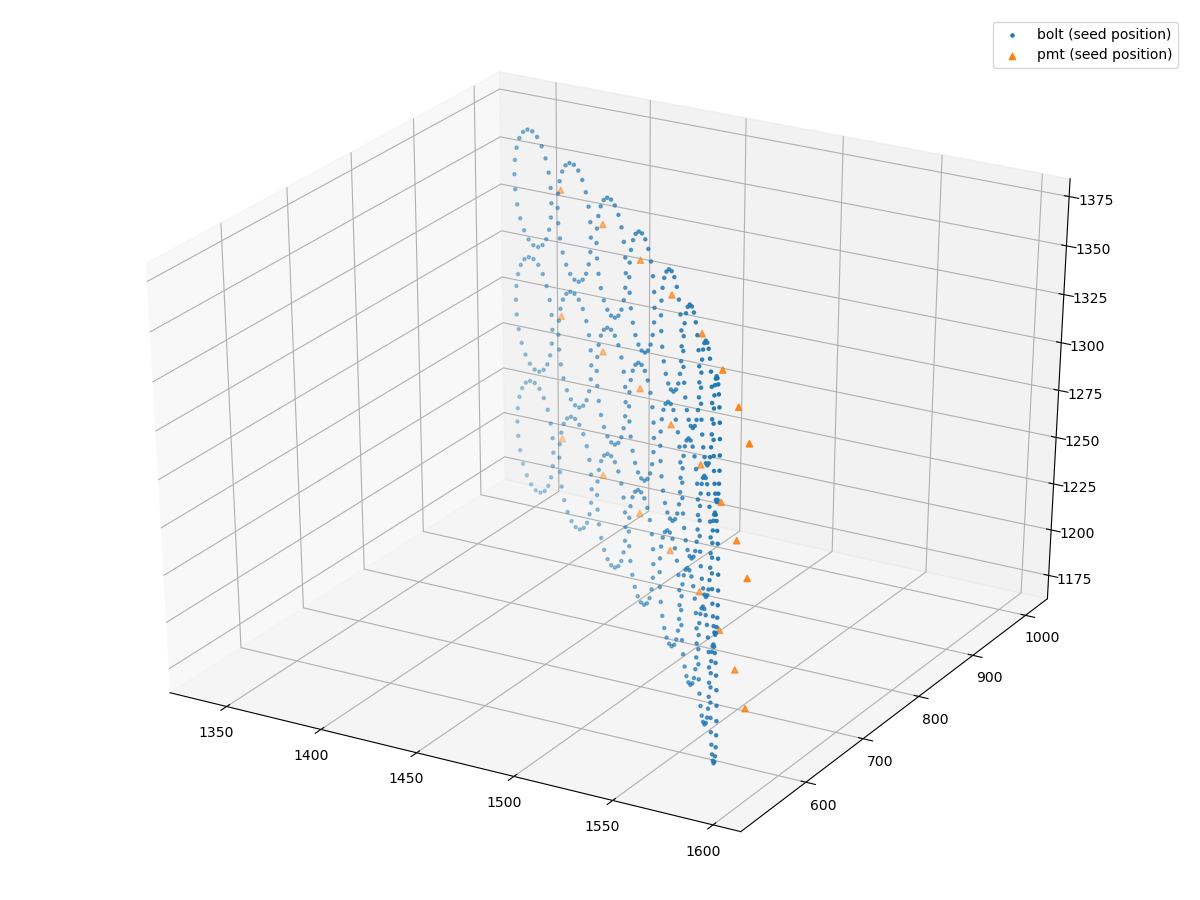

In [10]:
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111, projection='3d')
bolt_array = np.stack(list(bolt_locations.values()))
pmt_array = np.stack(list(pmt_locations.values()))
ax.scatter(bolt_array[:,0], bolt_array[:,1], bolt_array[:,2], marker='.', label="bolt (seed position)")
ax.scatter(pmt_array[:,0], pmt_array[:,1], pmt_array[:,2], marker='^', label="pmt (seed position)")
plt.legend(loc=0)
fig.tight_layout()

<IPython.core.display.Javascript object>


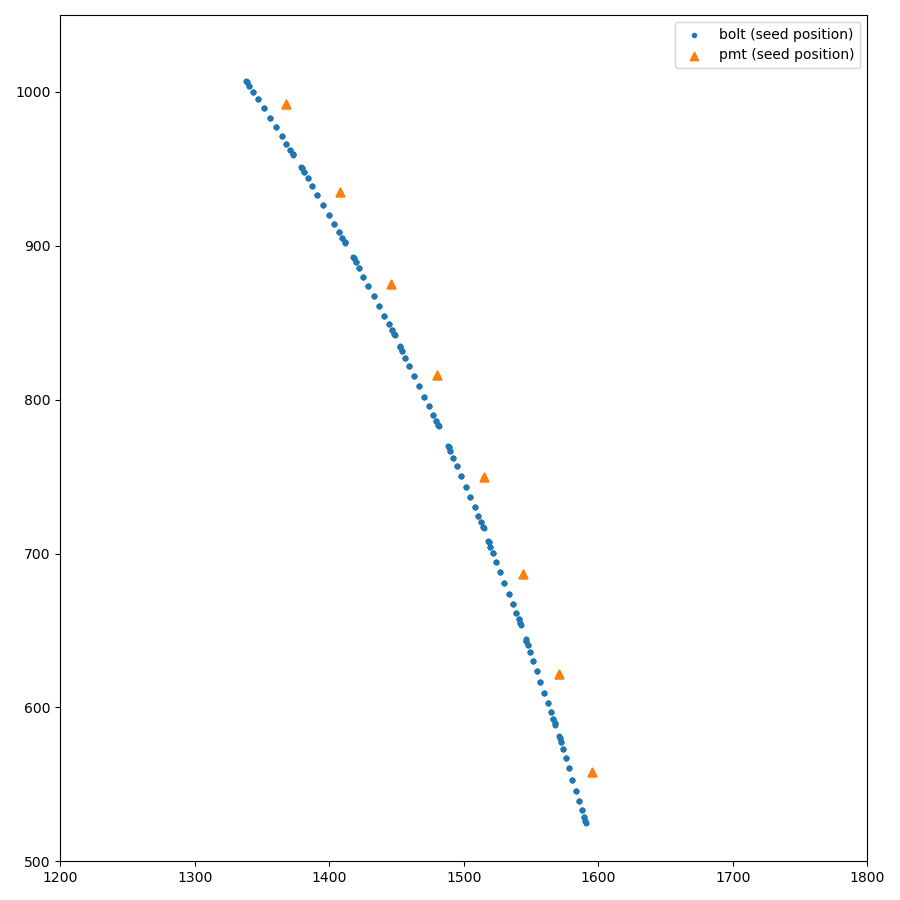

In [11]:
fig, ax = plt.subplots(figsize=(9,9))
bolt_array = np.stack(list(bolt_locations.values()))
pmt_array = np.stack(list(pmt_locations.values()))
ax.scatter(bolt_array[:,0], bolt_array[:,1], marker='.', label="bolt (seed position)")
ax.scatter(pmt_array[:,0], pmt_array[:,1], marker='^', label="pmt (seed position)")
ax.set_ylim((500,1050))
ax.set_xlim((1200,1800))
plt.legend(loc=0)
fig.tight_layout()

In [12]:
fitter_pmts = fit.PhotogrammetryFitter(common_image_pmt_locations, pmt_locations,
                                       focal_length, principle_point, radial_distortion)
fitter_bolts = fit.PhotogrammetryFitter(common_image_bolt_locations, common_bolt_locations,
                                       focal_length, principle_point, radial_distortion)
fitter_all = fit.PhotogrammetryFitter(common_image_feature_locations, common_feature_locations,
                                       focal_length, principle_point, radial_distortion)

In [13]:
camera_rotations, camera_translations, reprojected_points = fitter_all.estimate_camera_poses(flags=cv2.SOLVEPNP_EPNP)

image 0 reprojection errors:    average: 3.8150626073280938    max: 15.641593515379347
image 1 reprojection errors:    average: 4.533567223317367    max: 14.913212046158701
image 2 reprojection errors:    average: 4.321208830231349    max: 16.71880813494374
image 3 reprojection errors:    average: 4.495039171236305    max: 19.178706840488523
image 4 reprojection errors:    average: 3.2586080752639646    max: 13.075960879662013
image 5 reprojection errors:    average: 2.9485194138102604    max: 8.920609148632014
image 6 reprojection errors:    average: 3.04969967611864    max: 8.840683416393173
image 7 reprojection errors:    average: 3.133182815382559    max: 9.893422072080835
image 8 reprojection errors:    average: 2.89412112794467    max: 10.660251742952104
image 9 reprojection errors:    average: 3.2301547109356763    max: 11.016871251686414
image 10 reprojection errors:    average: 4.061302264414973    max: 14.776616141161451
image 11 reprojection errors:    average: 3.45055425951

In [14]:
max = 0
im = ""
feat = ""
im2 = ""
feat2 = ""
for i, ii in reprojected_points.items():
    for f, ff in ii.items():
        if linalg.norm(ff-image_feature_locations[i][f]) > max:
            im3 = im2
            feat3 = feat2
            im2 = im
            feat2 = feat
            im = i
            feat = f
print(im, feat, fitter_all.image_index[im])
print(im2, feat2, fitter_all.image_index[im2])
print(im3, feat3, fitter_all.image_index[im3])

240 00810-22 14
240 00810-21 14
240 00810-20 14


<IPython.core.display.Javascript object>


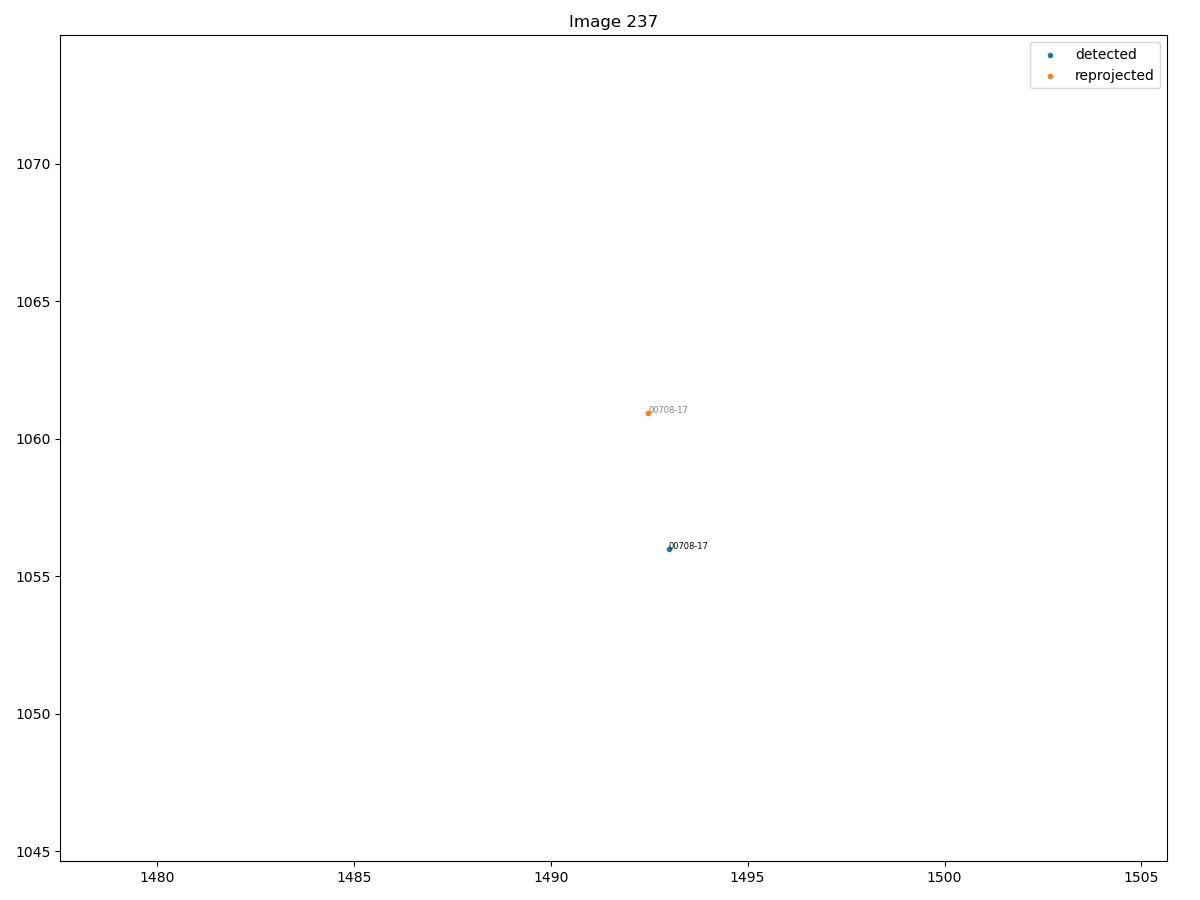

In [85]:
test_image = 11
fig, ax = plt.subplots(figsize=(12,9))
coords = np.stack(list(image_feature_locations[fitter_pmts.index_image[test_image]].values()))
repro_coords = np.stack(list(reprojected_points[fitter_pmts.index_image[test_image]].values()))
ax.scatter(coords[:,0], 3000-coords[:,1], marker='.', label='detected')
ax.scatter(repro_coords[:,0], 3000-repro_coords[:,1], marker='.', label='reprojected')
for t, f in image_feature_locations[fitter_pmts.index_image[test_image]].items():
    ax.text(f[0], 3000-f[1], t, size=6, zorder=4, color='k')
for t, f in reprojected_points[fitter_pmts.index_image[test_image]].items():
    ax.text(f[0], 3000-f[1], t, size=6, zorder=4, color='gray')
ax.set_title("Image {}".format(fitter_pmts.index_image[test_image]))
ax.set_ylim(0, 3000)
ax.set_xlim(0, 4000)
plt.legend(loc=0)
fig.tight_layout()

<IPython.core.display.Javascript object>


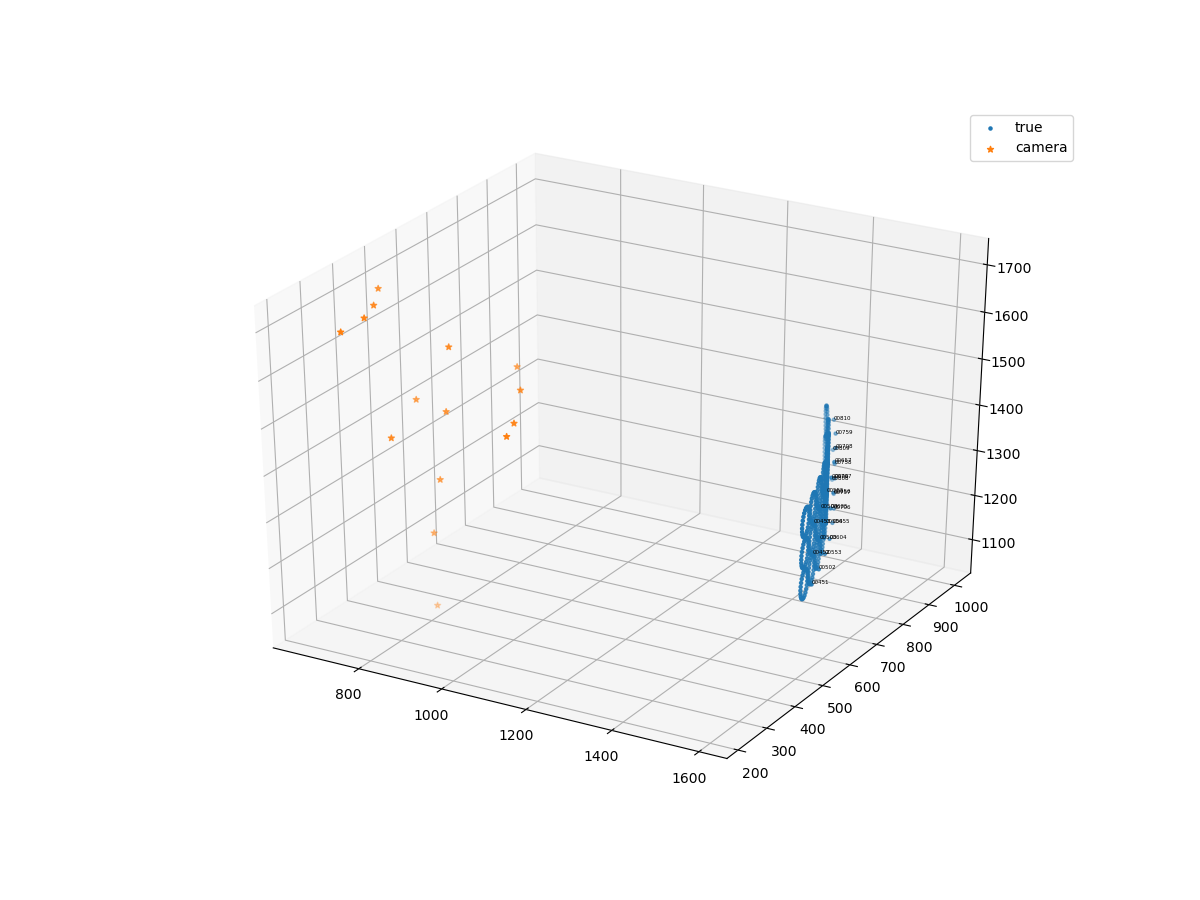

In [19]:
camera_orientations, camera_positions = fit.camera_world_poses(camera_rotations, camera_translations)
fig = plt.figure(figsize=(12,9))
pmt_array = np.stack(list(pmt_locations.values()))
feat_array = np.stack(list(common_feature_locations.values()))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(feat_array[:,0], feat_array[:,1], feat_array[:,2], marker='.', label="true", zorder=2)
for i, f in enumerate(pmt_locations.keys()):
    ax.text(pmt_array[i,0], pmt_array[i,1], pmt_array[i,2], f[:5], size=4, zorder=4, color='k') 
ax.scatter(camera_positions[:,0], camera_positions[:,1], camera_positions[:,2], marker='*', label="camera", zorder=1)
plt.legend(loc=0)

In [20]:
camera_rotations, camera_translations, reco_locations = fitter_all.bundle_adjustment(camera_rotations, camera_translations)

`ftol` termination condition is satisfied.
Function evaluations 9450, initial cost 5.4958e+04, final cost 1.3048e+04, first-order optimality 1.07e+01.
mean reprojection error: 1.6412068253329883
max reprojection error: 12.030219241835178


In [21]:
errors, reco_transformed, scale, R, translation, location_mean = fit.kabsch_errors(
    common_feature_locations, reco_locations)
print("mean reconstruction error:", linalg.norm(errors, axis=1).mean())
print("max reconstruction error:", linalg.norm(errors, axis=1).max())

mean reconstruction error: 1.6288903161912067
max reconstruction error: 5.53796103213493


In [22]:
camera_orientations, camera_positions = fit.camera_world_poses(camera_rotations, camera_translations)
camera_orientations = np.matmul(R, camera_orientations)
camera_positions = camera_positions - translation
camera_positions = scale*R.dot(camera_positions.transpose()).transpose() + location_mean

<IPython.core.display.Javascript object>


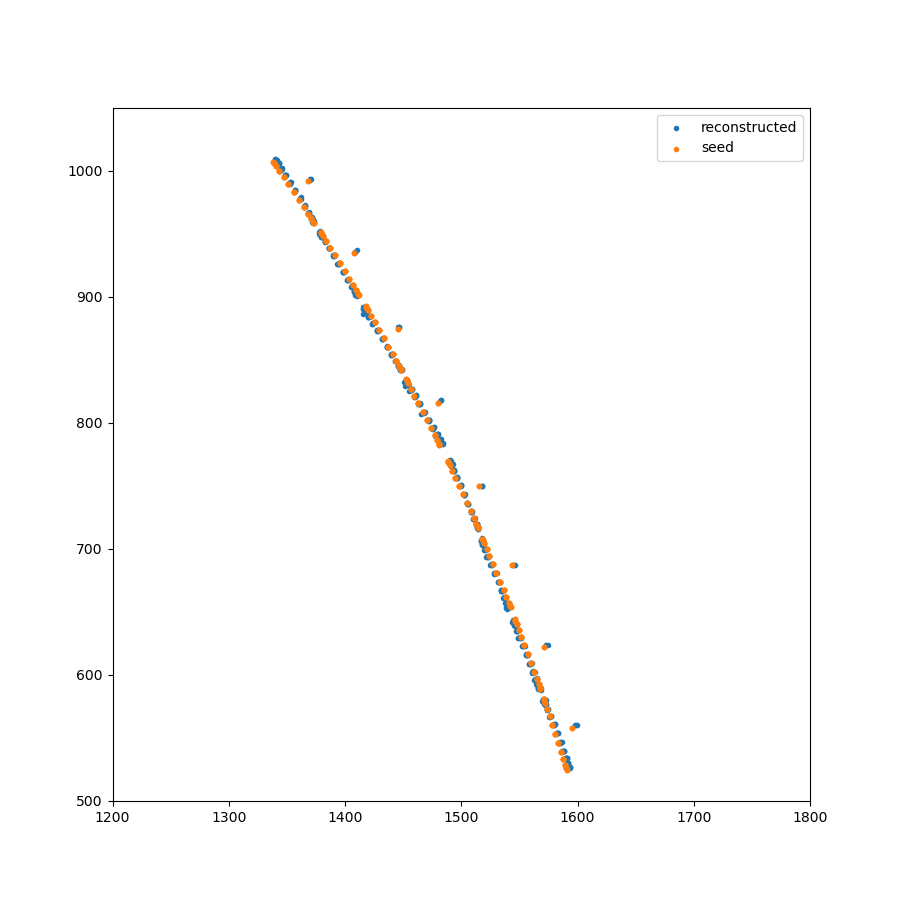

In [86]:
true_array = np.stack(list(common_feature_locations.values()))
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111)
ax.scatter(reco_transformed[:,0], reco_transformed[:,1], marker='.', label="reconstructed")
ax.scatter(true_array[:,0], true_array[:,1], marker='.', label="seed")
ax.set_ylim((500,1050))
ax.set_xlim((1200,1800))
#for i, f in enumerate(pmt_locations.keys()):
#    ax.text(reco_transformed[i,0], reco_transformed[i,1], f, size=4, zorder=1, color='k') 
#ax.scatter(camera_positions[:,0], camera_positions[:,1], camera_positions[:,2], marker='*', label="camera")
plt.legend(loc=0)

<IPython.core.display.Javascript object>


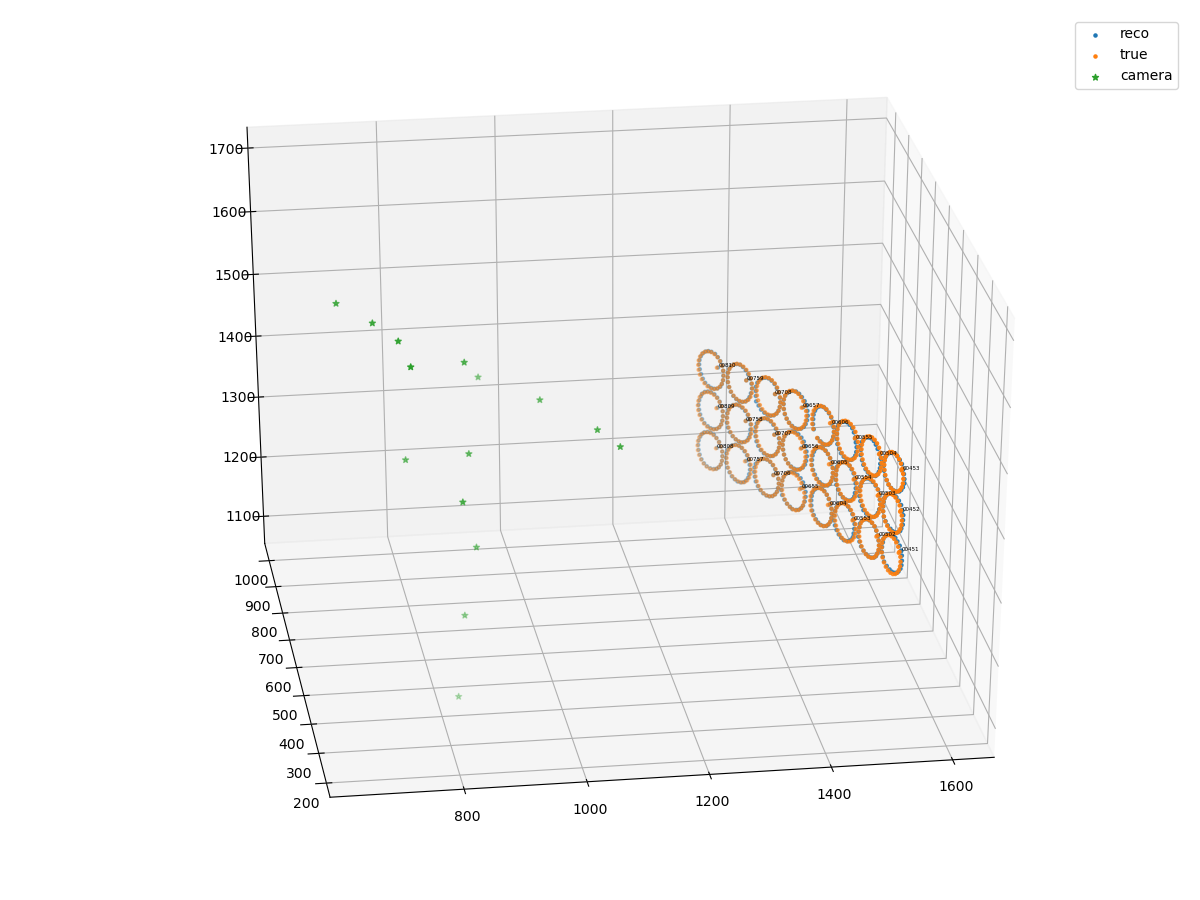

In [87]:
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(reco_transformed[:,0], reco_transformed[:,1], reco_transformed[:,2], marker='.', label="reco", zorder=3)
ax.scatter(true_array[:,0], true_array[:,1], true_array[:,2], marker='.', label="true", zorder=2)
for i, f in enumerate(pmt_locations.keys()):
    ax.text(reco_transformed[i,0], reco_transformed[i,1], reco_transformed[i,2], f[:5], size=4, zorder=4, color='k') 
ax.scatter(camera_positions[:,0], camera_positions[:,1], camera_positions[:,2], marker='*', label="camera", zorder=1)
plt.legend(loc=0)
fig.tight_layout()

<IPython.core.display.Javascript object>


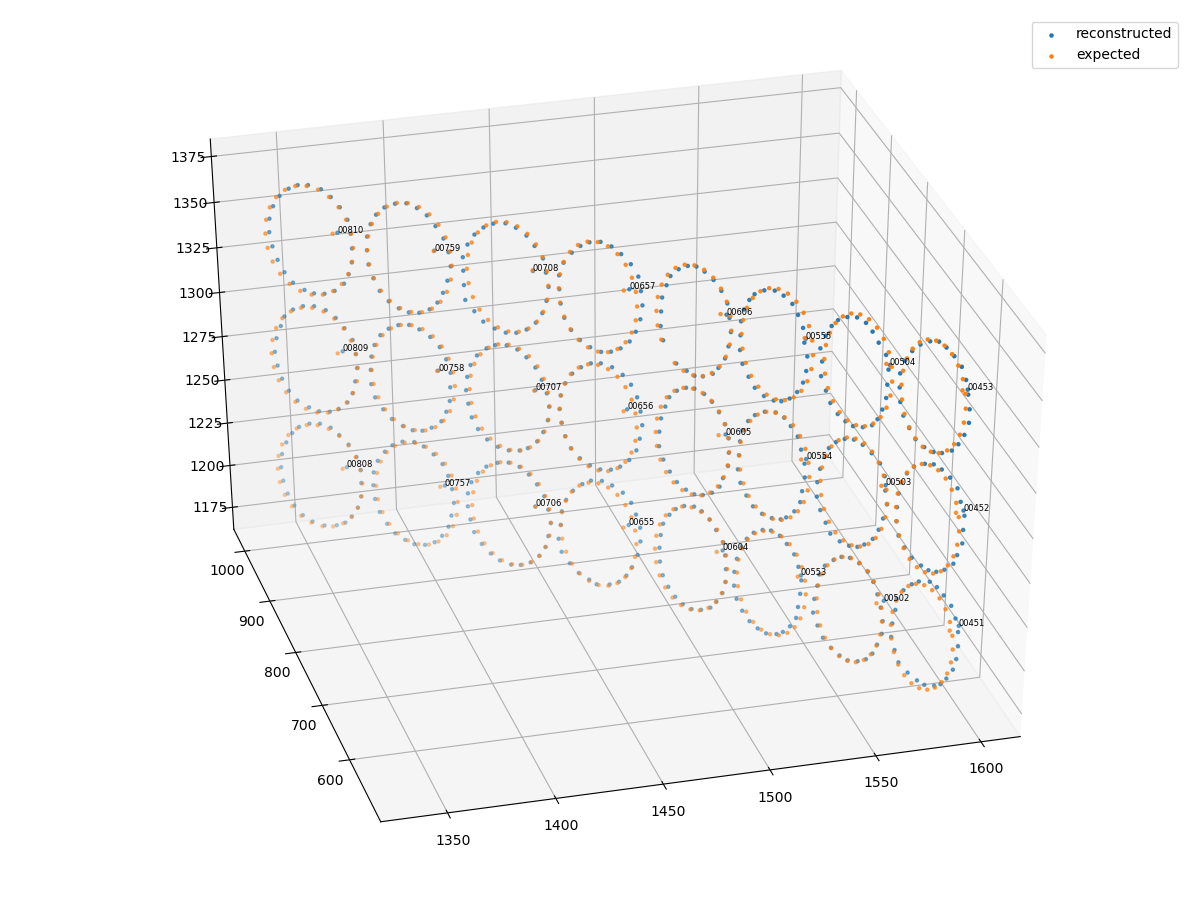

In [88]:
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(reco_transformed[:,0], reco_transformed[:,1], reco_transformed[:,2], marker='.', label="reconstructed", zorder=3)
ax.scatter(true_array[:,0], true_array[:,1], true_array[:,2], marker='.', label="expected", zorder=2)
for i, f in enumerate(pmt_locations.keys()):
    ax.text(reco_transformed[i,0], reco_transformed[i,1], reco_transformed[i,2], f[:5], size=6, zorder=4, color='k') 
#ax.scatter(camera_positions[:,0], camera_positions[:,1], camera_positions[:,2], marker='*', label="camera", zorder=1)
plt.legend(loc=0)
fig.tight_layout()

<IPython.core.display.Javascript object>


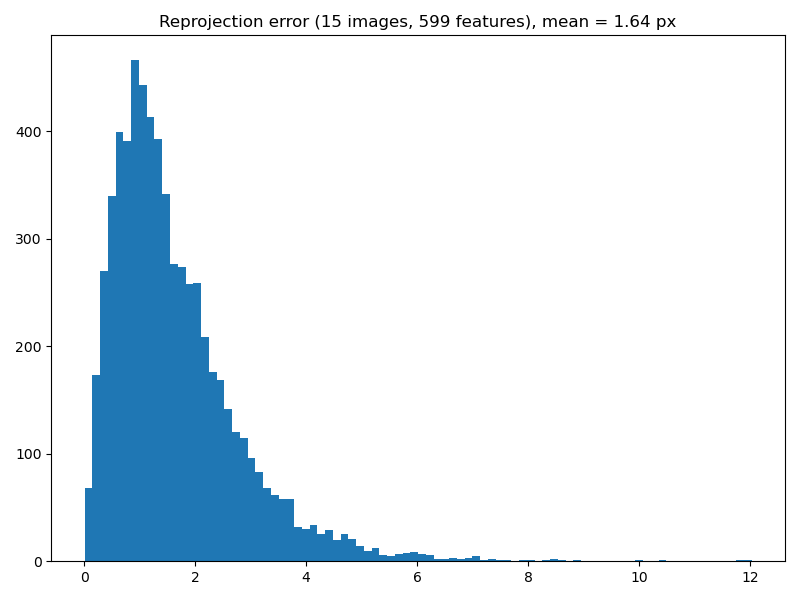

In [89]:
fig, ax = plt.subplots(figsize=(8,6))
reprojection_errors = fitter_all.reprojection_errors(fitter_all.camera_rotations, fitter_all.camera_translations, fitter_all.reco_locations)
reprojection_errors = linalg.norm(reprojection_errors.reshape((-1,2)), axis=1)
ax.hist(reprojection_errors, bins='auto')
ax.set_title("Reprojection error ({} images, {} features), mean = {:.2f} px".format(
    nimages, nfeatures, reprojection_errors.mean()))
fig.tight_layout()

In [90]:
print(np.array(np.unravel_index(np.argsort(linalg.norm(fitter_all.reprojected_locations()-fitter_all.image_feature_locations, axis=2).ravel()), (nimages, nfeatures))))
print(linalg.norm(fitter_all.reprojected_locations()-fitter_all.image_feature_locations, axis=2)[1, 90])
print(fitter_all.index_feature[323])

[[  0   6   6 ...   9   2   1]
 [  0 289 290 ... 323  18  90]]
12.030219241835178
00655-13


<IPython.core.display.Javascript object>


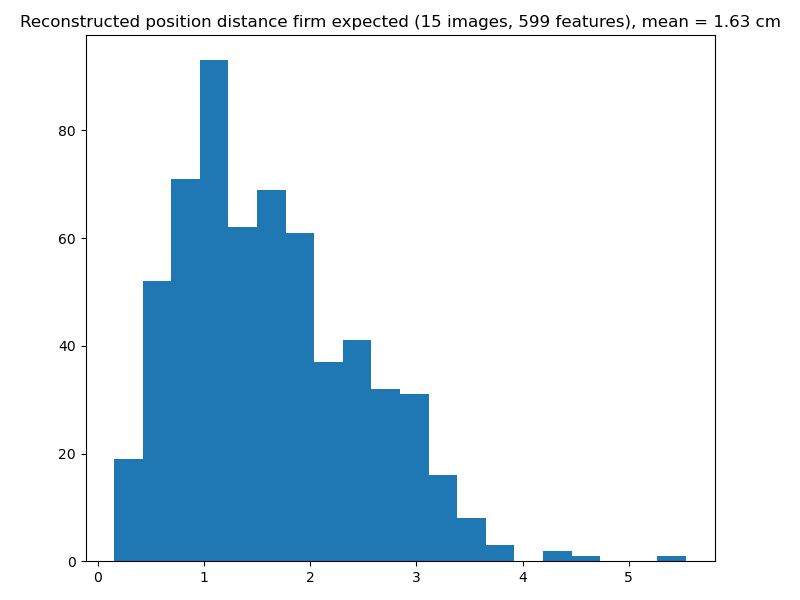

In [93]:
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(linalg.norm(errors, axis=1), bins='auto')
ax.set_title("Reconstructed position distance firm expected ({} images, {} features), mean = {:.2f} cm".format(
    nimages, nfeatures, linalg.norm(errors, axis=1).mean()))
fig.tight_layout()

In [94]:
fitter_all.save_result("SK_demo2_features.txt", "SK_demo2_cameras.txt")